# Extracting data from DORIS RINEX files

We will need the following python libraries (standard and from the AcademicSoftware module):

In [1]:
# import dsoclasses
from dsoclasses.rinex.doris.rinex import DorisRinex
from dsoclasses.time.pyattotime import at2pt
# import modules for plotting ...
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
import numpy as np

Specify the filename (and path) of the input DORS RINEX file

In [2]:
drinex = "../../data/s6arx24001.001"

Create a `DorisRinex` instance using the filename. This will read off header infor from the RINEX file (at construction). Later on, we will use the instance to loop through its contents. We'll call the instance `rnx`.

In [3]:
rnx = DorisRinex(drinex)

Since we have read the header info at construction, we can browse basic info. E.g. iterate through the involved beacons and print out their details, as recorded in the RINEX:

In [4]:
# Loop through the RINEX beacons ...
for beacon in rnx.beacons:
    print(f'Domes {beacon['domes']:9s} Id {beacon['id']:4s} Name {beacon['name']:20s} Type {beacon['type']:1d} Num {beacon['num']:3s}')

Domes 49804S004 Id COBB Name COLD BAY             Type 3 Num D01
Domes 40127S009 Id YEMB Name YELLOWKNIFE          Type 4 Num D02
Domes 43001S005 Id THUB Name THULE                Type 3 Num D03
Domes 40405S043 Id GONC Name GOLDSTONE            Type 4 Num D04
Domes 40451S178 Id GRFB Name GREENBELT            Type 3 Num D05
Domes 40503S006 Id SOFC Name SOCORRO              Type 3 Num D06
Domes 49914S003 Id MIAB Name MIAMI                Type 4 Num D07
Domes 41201S002 Id MNAC Name MANAGUA              Type 3 Num D08
Domes 42005S003 Id SCSC Name SANTA CRUZ           Type 4 Num D09
Domes 97205S001 Id LAOB Name LE LAMENTIN          Type 3 Num D10
Domes 97301S006 Id KRWB Name KOUROU               Type 4 Num D11
Domes 41508S005 Id SJVC Name SAN JUAN             Type 4 Num D12
Domes 41781S001 Id HROC Name HANGA ROA            Type 4 Num D13
Domes 41507S008 Id RISC Name RIO GRANDE           Type 3 Num D14
Domes 66018S002 Id BEMB Name BELGRANO             Type 3 Num D15
Domes 30604S003 Id TRJB N

We can use the `DorisRinex` instance `rnx` to loop through observations. We are looping for:
 - every observation block (`for block in rnx`); a **block** is a collection of observations performed at the same time instance. It can contain measurements from different beacons and holds values specific to the block (e.g. observation epoch, flag and clock correction)
 - every beacon in the block (`for beacon, data in block`); this will return a collection (i.e. a `dictionary`) where the **key** is the beacon (specified by its `id`) and the values are the DORIS observarbles (see [DORIS RINEX format specification](https://ids-doris.org/documents/BC/data/RINEX_DORIS.pdf) pg. 16)

Let's go ahead and inspect what such a loop would actually produce, considering only the first observation block:

In [5]:
# for every block in RINEX ...
for block in rnx:
    # here is what the block holds:
    print(f"Block t={block.t().strftime("%Y-%m-%d %H:%M:%S.%f")}, clock offset={block.clock_offset()}, flag={block.flag()}, num. beacons={block.nbeacons()}\n")
    # for every beacon in the block ...
    for beacon, data in block:
        print(f"Beacon: {beacon} Observations {data}\n")
    # stop after the first block
    break

Block t=2024-01-01 00:00:27.129948, clock offset=1.740551554, flag=0, num. beacons=3

Beacon: D01 Observations {'L1': {'value': -3425417.873, 'm1': None, 'm2': None}, 'L2': {'value': -2327925.282, 'm1': None, 'm2': None}, 'C1': {'value': -44561256.185, 'm1': 1, 'm2': 1}, 'C2': {'value': -44561151.349, 'm1': 1, 'm2': 1}, 'W1': {'value': -121.15, 'm1': None, 'm2': 7}, 'W2': {'value': -109.6, 'm1': None, 'm2': 7}, 'F': {'value': -463.714, 'm1': None, 'm2': None}, 'P': {'value': 991.0, 'm1': None, 'm2': 0}, 'T': {'value': -2.5, 'm1': None, 'm2': 1}, 'H': {'value': 84.0, 'm1': None, 'm2': 1}}

Beacon: D02 Observations {'L1': {'value': -3413218.021, 'm1': None, 'm2': None}, 'L2': {'value': -2325523.752, 'm1': None, 'm2': None}, 'C1': {'value': -51962978.778, 'm1': 1, 'm2': 2}, 'C2': {'value': -51963008.662, 'm1': 1, 'm2': 2}, 'W1': {'value': -120.45, 'm1': None, 'm2': 7}, 'W2': {'value': -110.3, 'm1': None, 'm2': 7}, 'F': {'value': -463.714, 'm1': None, 'm2': None}, 'P': {'value': 1004.0, 'm

We can now extract all observations of a given type (e.g. phase, code, signal-strength, etc...) for a specific beacon. We'll choose Dionysos (DIOB/D31) site and loop through the RINEX to extract all temperature and humidity measurements made by the beacon.

In [6]:
# DORIS beacon
diob = 'D31'

# store measurements here (time, temperature, humidity)
t = []; T = []; H = [];

# for every block in RINEX ...
for block in rnx:
    # for every beacon in the (current) data block ...
    for beacon, data in block:
        # match the site
        if beacon == diob:
            # got DIOB! store the data
            t.append(block.t())
            T.append(data['T']['value'])
            H.append(data['H']['value'])

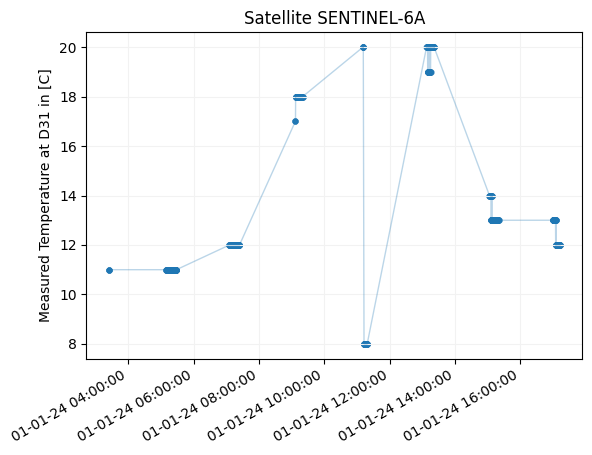

In [7]:
# Plot collected data:
# create a scatterplot of extracted Temperature and Humidity values w.r.t. time

# note that we will transform the epochs to python's instrinsic datetime type
plt.scatter([at2pt(ti) for ti in t], T, alpha=0.5, s=12)
plt.plot([at2pt(ti) for ti in t], T, alpha=0.3, linewidth=1)

plt.grid(color='0.95')
plt.ylabel(f"Measured Temperature at {diob} in [C]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()

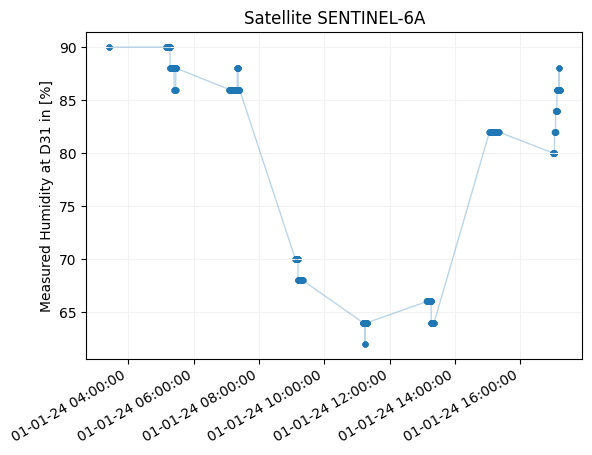

In [8]:
plt.scatter([at2pt(ti) for ti in t], H, alpha=0.5, s=12)
plt.plot([at2pt(ti) for ti in t], H, alpha=0.3, linewidth=1)

plt.grid(color='0.95')
plt.ylabel(f"Measured Humidity at {diob} in [%]")
plt.title(f"Satellite {rnx.sat_name}")

# Format the datetime x-axis
ax = plt.gca()
ax.xaxis.set_major_formatter(mdates.DateFormatter("%d-%m-%y %H:%M:%S"))
# auto-rotate date labels for readability
plt.gcf().autofmt_xdate()

plt.show()